In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data = pd.read_csv("./Datasets/train.csv")
(train_data.sample(10))

,text,label
1808,Ab biraj भट्ट चाहियो रजतपट अंकल🙏🙏🙏 please 🙏🙏🙏🙏,2
2246,गाउँ पस्न निषेध गरौ,0
1110,सकारात्मक सोच भएका हेम थापा । यतिका सहयोगमा लग...,1
2693,"रहर त मेरोपनि ""नभाको""कहां होर",0
1829,दिलिप रायमाझी जी हार्दिक बधाई तथा शुभकामना ।,1
2114,रबि दाइ एउटा् कुरा सोद्न अनुमती मागे mcc बारेम...,0
5292,तपाइँ को रिहाइ लागी बोल्दा उनि अनायासै दस दिन ...,1
662,प्रचण्ड र माओवादीको यो हविगत भएको आफ्नै कारणले...,2
5648,रबि दाइले MCC को विपक्षमा टेलिभिजन मा बोलिराख...,0
764,Parchanda is a great leader and प्रचण्ड को त...,2


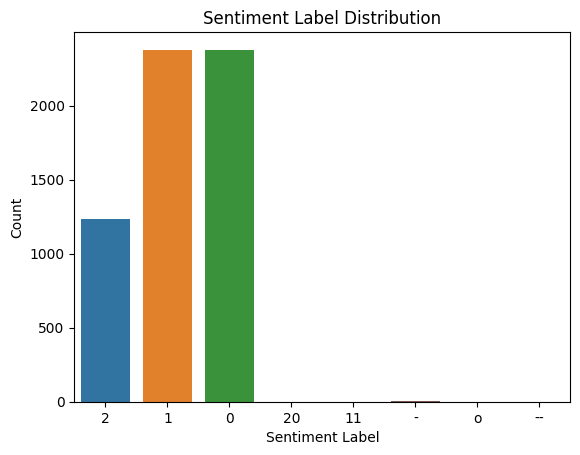

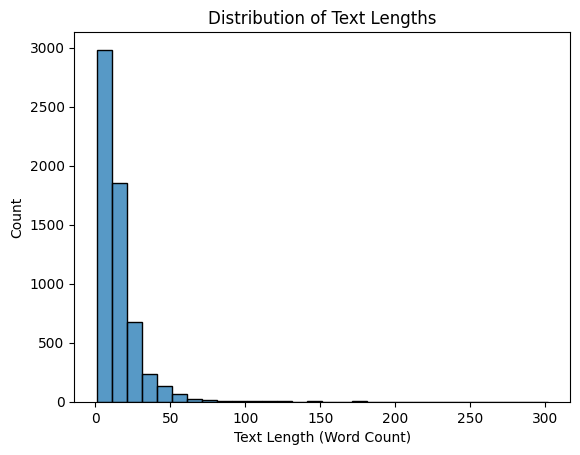

In [3]:
train_data['text'] = train_data['text'].str.lower()


sns.countplot(x='label', data=train_data)
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()



train_data['text_length'] = train_data['text'].apply(lambda x: len(str(x).split()))
sns.histplot(train_data['text_length'], bins=30)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (Word Count)')
plt.ylabel('Count')
plt.show()

In [4]:
label_mapping = {'11': '1', '20': '2', 'o': '0'}
train_data['label'] = train_data['label'].replace(label_mapping)

# Drop rows with invalid labels ('-', '--')
train_data = train_data[~train_data['label'].isin(['-', '--'])]

# Drop null values in the text column
train_data.dropna(subset=['text'], inplace=True)

In [5]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [6]:
def remove_special_characters(text):
    # Remove emojis (assuming they are in unicode format)
    text = re.sub(r'[^\u0000-\uFFFF]', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

train_data['text'] = train_data['text'].apply(remove_special_characters)

#  Tokenization and removing stopwords
nltk.download('punkt')
nltk.download('stopwords')

def remove_stopwords_and_tokenize(text):
    stop_words = set(stopwords.words('nepali'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

train_data['text'] = train_data['text'].apply(remove_stopwords_and_tokenize)

# Lemmatization using WordNetLemmatizer for Nepali
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def apply_lemmatization(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(lemmatized_words)

train_data['text'] = train_data['text'].apply(apply_lemmatization)

# Display the preprocessed text data
print(train_data.head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bilson\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Bilson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Bilson\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text label  text_length
0  बजर ल जसर टरनड चनज गरय य हरद ततकल परफट बकङ आउन...     2           24
1  1000 अकल घटक नपस 200 अकल बढन ठल कर हइन अझ पन क...     1           16
2  हइन य सनम बक ल bonus घसण गरक २ महन भय book clo...     2           28
3    ख mbjc परत कततम र10ल बढर आज र1100 मतर भय 10कततक     2           12
4                                             रमर भय     1            2


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [8]:
X = train_data['text']
y = train_data['label']

# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data with TF-IDF vectorizer
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

#Transform the testing data with TF-IDF vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Check the shape of the TF-IDF matrices
print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)

Shape of X_train_tfidf: (4794, 8449)
Shape of X_test_tfidf: (1199, 8449)


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [10]:

label_encoder = LabelEncoder()
all_labels = list(y_train.unique()) + list(y_test.unique())
label_encoder.fit(all_labels)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

#  Convert text data to sequences and pad the sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_sequence_length = max(max(len(seq) for seq in X_train_sequences),
                         max(len(seq) for seq in X_test_sequences))

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)


#  Create the LSTM model with Dropout and L2 Regularization
embedding_dim = 100
lstm_units = 64

In [11]:
# model = Sequential()
# model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim, input_length=max_sequence_length))
# model.add(LSTM(units=lstm_units, kernel_regularizer=l2(0.01)))  # L2 regularization
# # model.add(Dropout(0.5))  # Dropout layer with 50% dropout rate
# model.add(Dense(units=num_classes, activation='softmax'))

# #  Compile and train the model with early stopping
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

# Train the model
batch_size = 32
epochs = 50
# history = model.fit(X_train_padded, y_train_categorical, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

# #  Evaluate the model on the test set
# loss, accuracy = model.evaluate(X_test_padded, y_test_categorical, batch_size=batch_size)
# print("Test Accuracy:", accuracy)


# plt.figure(figsize=(8, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()

In [12]:
# model = Sequential()
# model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim, input_length=max_sequence_length))
# model.add(LSTM(units=lstm_units, return_sequences=True))
# model.add(Bidirectional(LSTM(units=lstm_units)))
# # model.add(Dropout(0.5))  # Dropout layer with 50% dropout rate
# model.add(Dense(units=num_classes, activation='softmax'))

# #  Compile and train the model with early stopping
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Early stopping to prevent overfitting
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# # Train the model
# batch_size = 32
# epochs = 50
# history = model.fit(X_train_padded, y_train_categorical, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

# #  Evaluate the model on the test set
# loss, accuracy = model.evaluate(X_test_padded, y_test_categorical, batch_size=batch_size)
# print("Test Accuracy:", accuracy)

# # Plot the training and validation loss curves
# plt.figure(figsize=(8, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()

In [13]:
# model = Sequential()
# model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim, input_length=max_sequence_length))
# model.add(Bidirectional(LSTM(units=lstm_units)))
# # model.add(Dropout(0.5))  # Dropout layer with 50% dropout rate
# model.add(Dense(units=num_classes, activation='softmax'))

# #  Compile and train the model with early stopping
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Early stopping to prevent overfitting
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# # Train the model
# batch_size = 32
# epochs = 50
# history = model.fit(X_train_padded, y_train_categorical, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

# # Evaluate the model on the test set
# loss, accuracy = model.evaluate(X_test_padded, y_test_categorical, batch_size=batch_size)
# print("Test Accuracy:", accuracy)

# # Plot the training and validation loss curves
# plt.figure(figsize=(8, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()
# plt.show()

Epoch 1/50
120/120 [==============================] - 17s 113ms/step - loss: 0.9237 - accuracy: 0.5510 - val_loss: 0.8122 - val_accuracy: 0.6236
Epoch 2/50
120/120 [==============================] - 12s 97ms/step - loss: 0.6088 - accuracy: 0.7502 - val_loss: 0.7615 - val_accuracy: 0.6830
Epoch 3/50
120/120 [==============================] - 12s 97ms/step - loss: 0.3982 - accuracy: 0.8488 - val_loss: 0.8796 - val_accuracy: 0.6840
Epoch 4/50
120/120 [==============================] - 12s 101ms/step - loss: 0.2906 - accuracy: 0.8936 - val_loss: 0.8834 - val_accuracy: 0.6705
Epoch 5/50
38/38 [==============================] - 1s 31ms/step - loss: 0.7552 - accuracy: 0.6889
Test Accuracy: 0.6889074444770813


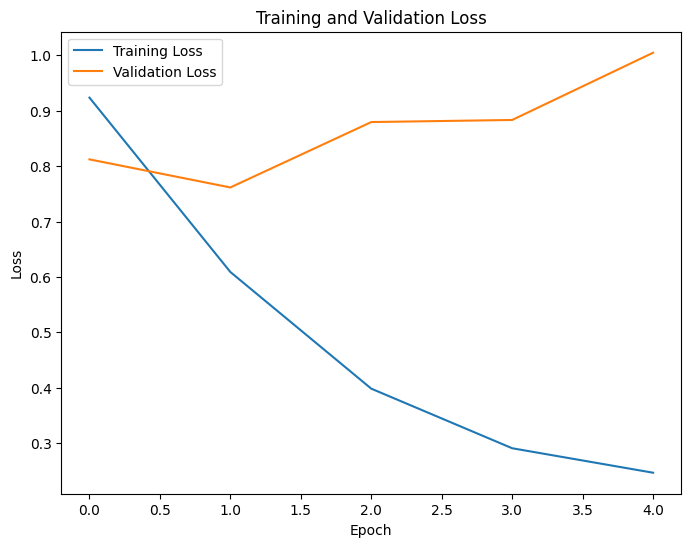

In [14]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(units=lstm_units, return_sequences=True))
model.add(Bidirectional(LSTM(units=lstm_units)))
# model.add(Dropout(0.5))  # Dropout layer with 50% dropout rate
model.add(Dense(units=num_classes, activation='softmax'))

#  Compile and train the model with early stopping
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
batch_size = 32
epochs = 50
history = model.fit(X_train_padded, y_train_categorical, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[early_stopping])

#  Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test_categorical, batch_size=batch_size)
print("Test Accuracy:", accuracy)

# Plot the training and validation loss curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

38/38 [==============================] - 2s 31ms/step


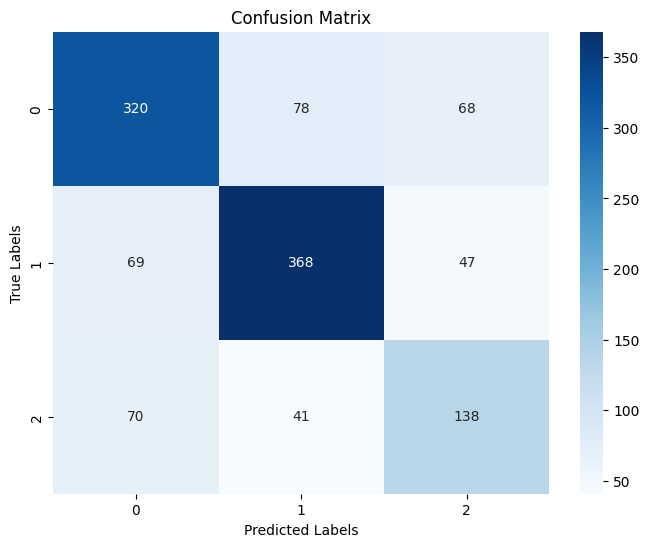

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the classes for the test set
y_pred = model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
def predict_sentiment(text):
    tokens = tokenizer.texts_to_sequences([text])
    padded_tokens = pad_sequences(tokens, maxlen=max_sequence_length, padding='pre', truncating='pre')
    predictions = model.predict(padded_tokens)
    predicted_class = predictions.argmax(axis=-1)[0]
    # predicted_sentiment = labelencoder.classes[predicted_class]
    return predicted_class


new_text = "औषधिमा भ्रष्टाचार गर्ने यो महा पापी हो।"
predicted_sentiment = predict_sentiment(new_text)
print("Predicted Sentiment:", predicted_sentiment)

1/1 [==============================] - 0s 56ms/step
Predicted Sentiment: 2


In [17]:
new_text = "मेरा पुर्खाको गृहजिल्ला तेर्हथुम पाथिभारामाता को सधै आर्शिवाद मिलोस भाई सहित परिवारलाई जयहोस"

# def remove_special_characters(text):
#     # Remove emojis (assuming they are in unicode format)
#     text = re.sub(r'[^\u0000-\uFFFF]', '', text)
#     # Remove special characters and punctuation
#     text = re.sub(r'[^\w\s]', '', text)
#     return text

# train_data['text'] = train_data['text'].apply(remove_special_characters)

# #  Tokenization and removing stopwords
# nltk.download('punkt')
# nltk.download('stopwords')

# def remove_stopwords_and_tokenize(text):

new_text = remove_special_characters(new_text)

new_text = remove_stopwords_and_tokenize(new_text)


predicted_sentiment = predict_sentiment(new_text)
print("Predicted Sentiment:", predicted_sentiment)

1/1 [==============================] - 0s 26ms/step
Predicted Sentiment: 1


In [19]:
import pickle
# save the model to disk
print(max_sequence_length)
filename = 'final_model.pkl'
pickle.dump(model, open(filename, 'wb'))

163
